# **Convolutional Neural Networks (CNN)**

## **Residual Networks (RasNet)**

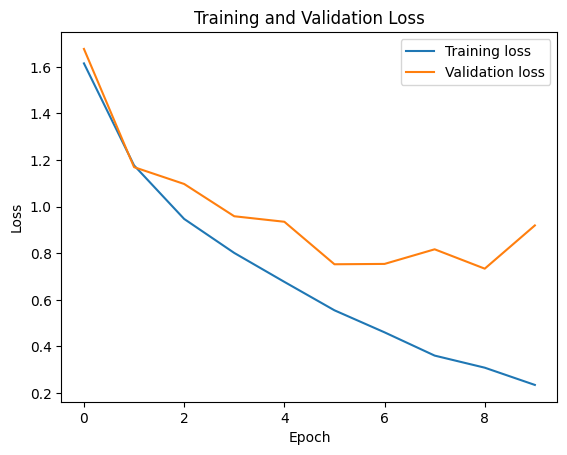

1563/1563 [==============================] - 771s 493ms/step - loss: 0.2351 - accuracy: 0.9191 - val_loss: 0.9196 - val_accuracy: 0.7463


In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from IPython.display import clear_output
from tensorflow.keras.callbacks import LambdaCallback
class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.epochs = 0
        self.figure = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.epochs += 1
        
        clear_output(wait=True)
        plt.plot([log['loss'] for log in self.logs], label='Training loss')
        plt.plot([log['val_loss'] for log in self.logs], label='Validation loss')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.show()


# Define the residual block
def residual_block(x, filters, kernel_size=3, stride=1):
    # Shortcut
    shortcut = x
    
    # First convolution layer
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # Second convolution layer
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)  # Stride is now 1
    x = BatchNormalization()(x)
    
    # Adjusting the shortcut dimensions if necessary
    if x.shape != shortcut.shape:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)  # Stride is applied here
        shortcut = BatchNormalization()(shortcut)
    
    # Adding the shortcut to the output
    x = Add()([x, shortcut])
    x = ReLU()(x)
    
    return x

# Define the ResNet-18 model
def resnet18():
    input = Input(shape=(32, 32, 3))
    x = Conv2D(64, (7, 7), padding='same', strides=2)(input)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    for _ in range(2):
        x = residual_block(x, 64)
    for _ in range(2):
        x = residual_block(x, 128, stride=2)
    for _ in range(2):
        x = residual_block(x, 256, stride=2)
    for _ in range(2):
        x = residual_block(x, 512, stride=2)
    x = GlobalAveragePooling2D()(x)
    output = Dense(10, activation='softmax')(x)
    model = Model(inputs=input, outputs=output)
    return model


# Build the model
model = resnet18()

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Load CIFAR-10 data
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0  # Normalize pixel values to be between 0 and 1

# Early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)
plot_losses = PlotLosses()

def on_epoch_end(epoch, logs):
    print(f"Epoch {epoch+1}, Accuracy: {logs['accuracy']:.4f}, Validation Accuracy: {logs['val_accuracy']:.4f}")


print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
# history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))
# Train the model with the callbacks
history = model.fit(
    train_images, 
    train_labels, 
    epochs=10,
    validation_data=(test_images, test_labels),
    callbacks=[plot_losses, early_stopping, model_checkpoint]
)


# **Obtain predictions**

In [2]:
import numpy as np


# Get the model's predictions
predictions = model.predict(test_images)

# Get the class with the highest probability for each sample
y_pred = np.argmax(predictions, axis=1)

# Flatten y_true
y_true = test_labels.flatten()


313/313 [==============================] - 10s 31ms/step


# **Visualization**

## **Confusion Matrix**

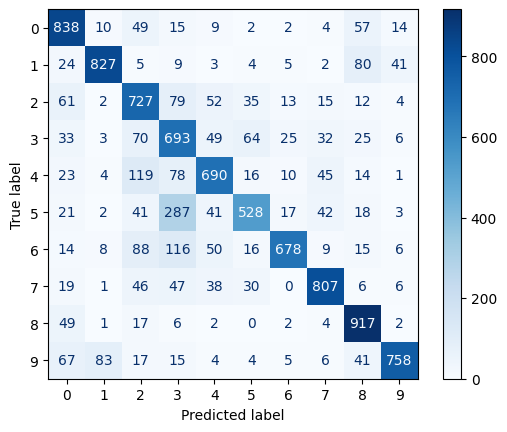

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=np.arange(10))

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(10)])
disp.plot(cmap=plt.cm.Blues)
plt.show()


## **ROC_Curve**

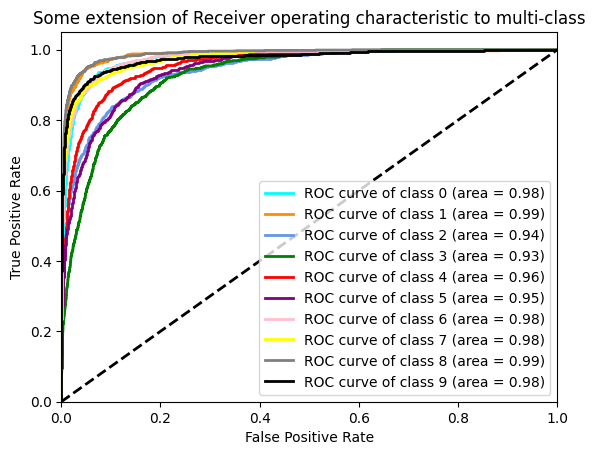

In [4]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the labels
y_bin_true = label_binarize(y_true, classes=np.arange(10))
n_classes = y_bin_true.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin_true[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'pink', 'yellow', 'grey', 'black'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


In [5]:
import optuna
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def create_model(lr):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def objective(trial):
    # Hyperparameters to be optimized
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    
    model = create_model(lr)  
    early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)
    
    # Assume you have train_images, train_labels, test_images, and test_labels defined elsewhere
    history = model.fit(train_images, 
                        train_labels, 
                        epochs=10, 
                        batch_size=batch_size,
                        validation_data=(test_images, test_labels),
                        callbacks=[early_stopping, model_checkpoint],
                        verbose=0)
    
    # Objective is to maximize validation accuracy
    return history.history['val_accuracy'][-1]

# Create a study object and specify the direction is 'maximize'.
study = optuna.create_study(direction='maximize')

# Optimize the study, the objective function is passed in the first argument.
study.optimize(objective, n_trials=100)

# Retrieve the best params
best_params = study.best_params

# Train the model with the best parameters and plot the training process
best_model = create_model(best_params['lr'])
history = best_model.fit(train_images, 
                         train_labels, 
                         epochs=10, 
                         batch_size=best_params['batch_size'],
                         validation_data=(test_images, test_labels))

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2023-10-15 07:08:52,859] A new study created in memory with name: no-name-302235c3-b6f8-475a-9f33-6b4b3dc87b65
C:\Users\lebel\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
[I 2023-10-15 07:12:18,571] Trial 0 finished with value: 0.7148000001907349 and parameters: {'lr': 0.0010264154237327014, 'batch_size': 64}. Best is trial 0 with value: 0.7148000001907349.
[I 2023-10-15 07:16:22,527] Trial 1 finished with value: 0.6330999732017517 and parameters: {'lr': 0.00011801374858080942, 'batch_size':

In [1]:

# Create a study object and specify the direction is maximize.
study = optuna.create_study(direction='maximize')

# Optimize the study, the objective function is passed in the first argument.
study.optimize(objective, n_trials=50)  # Example: running optimization for 50 trials.

# Results
best_params = study.best_params
best_score = study.best_value

print(f"Best parameters: {best_params} (score: {best_score:.4f})")


NameError: name 'optuna' is not defined

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interp
from itertools import cycle

# Assume best_model is trained and available
y_pred = best_model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot encoded to single integer
y_true = test_labels.ravel()  # Assuming test_labels is a column vector

# Plotting the confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Binarize the labels for ROC curve
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes = y_true_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
fig, ax = plt.subplots(figsize=(10, 10))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


NameError: name 'best_model' is not defined